In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import ops
from geographiclib.geodesic import Geodesic
from shapely.geometry import LineString, MultiLineString
from scipy.ndimage.filters import gaussian_filter

# low-pass filter
def raster_filter(src, gamma):
    dst = src.copy()
    dst.values = gaussian_filter(dst.values.astype(np.float32),gamma,mode='constant')
    return dst

In [2]:
# plotting modules
import matplotlib.pyplot as plt
from matplotlib import cm, colors
%matplotlib inline

## Define Parameters

In [3]:
# Gaussian filter sigma, km
sigmakm = 10

## Read Raster

In [4]:
# regridded from GEBCO 2019
da = xr.open_dataarray('GEBCO_2019.15min.nc').squeeze(drop=True)
da

<xarray.DataArray 'elevation' (lat: 720, lon: 1440)>
[1036800 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
Attributes:
    long_name:           Elevation relative to sea level
    sdn_parameter_name:  Sea floor height (above mean sea level) {bathymetric...
    sdn_parameter_urn:   SDN:P01::ALATZZ01
    sdn_uom_name:        Metres
    sdn_uom_urn:         SDN:P06::ULAA
    standard_name:       height_above_reference_ellipsoid
    units:               m

## Raster Gaussian Filtering
Note: see other notebooks for processing on ellipsoid for better accuracy

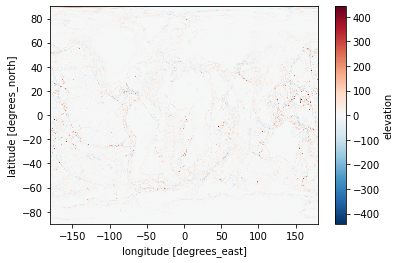

In [5]:
# roughly estimate filtering radius in pixels
radius = float(sigmakm/(100*da.lon.diff(dim='lon'))[0])
raster = da - raster_filter(da, radius)
raster.plot()

## Save Gaussian Filtered Raster

In [6]:
!rm -fr grav_29.1.10min.{sigmakm}km.nc
raster.to_netcdf(f'GEBCO_2019.15min.{sigmakm}km.nc')

## Vectorize Gaussian Filtered Raster

In [7]:
!gdal_contour -a z -i 20 GEBCO_2019.15min.{sigmakm}km.nc GEBCO_2019.15min.{sigmakm}km.shp

0...10...20...30...40...50...60...70...80...90...100 - done.


## Read vector file

In [8]:
df = gpd.read_file(f'GEBCO_2019.15min.{sigmakm}km.shp')
df.geometry = df.geometry.apply(lambda geom: MultiLineString([geom]) if geom.geom_type == 'LineString' else geom)
df = df.explode("geometry").reset_index(drop=True)
df

,ID,z,geometry
0,0,-320.0,"LINESTRING (179.85340 90.00000, 179.85340 89.8..."
1,1,-320.0,"LINESTRING (-180.00000 89.84982, -179.87500 89..."
2,2,-300.0,"LINESTRING (179.82295 90.00000, 179.82295 89.8..."
3,3,-300.0,"LINESTRING (-180.00000 89.81513, -179.87500 89..."
4,4,-280.0,"LINESTRING (179.79251 90.00000, 179.79251 89.8..."
...,...,...,...
163314,163314,160.0,"LINESTRING (179.73991 -90.00000, 179.73991 -89..."
163315,163315,180.0,"LINESTRING (-180.00000 -89.77927, -179.87500 -..."
163316,163316,180.0,"LINESTRING (179.78584 -90.00000, 179.78584 -89..."
163317,163317,200.0,"LINESTRING (-180.00000 -89.82857, -179.87500 -..."


<AxesSubplot:>

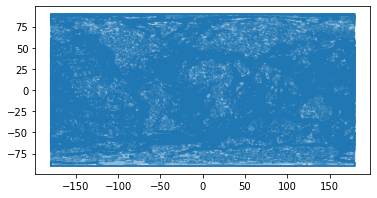

In [9]:
df.sample(10000).plot(alpha=0.5)

In [10]:
# helper function
def segmentize(line):
    return list(map(LineString, zip(line.coords[:-1], line.coords[1:])))

df['geom'] = df.geometry.apply(lambda geom: segmentize(geom))
df = df.explode("geom").reset_index(drop=True)
df = df.rename(columns={'geometry':'_','geom': 'geometry'}).drop(['_'], axis=1)
df

,ID,z,geometry
0,0,-320.0,"LINESTRING (179.85340 90.00000, 179.85340 89.8..."
1,0,-320.0,"LINESTRING (179.85340 89.87500, 179.87500 89.8..."
2,0,-320.0,"LINESTRING (179.87500 89.85051, 180.00000 89.8..."
3,1,-320.0,"LINESTRING (-180.00000 89.84982, -179.87500 89..."
4,1,-320.0,"LINESTRING (-179.87500 89.84982, -179.85286 89..."
...,...,...,...
1822987,163317,200.0,"LINESTRING (-179.87500 -89.82857, -179.83173 -..."
1822988,163317,200.0,"LINESTRING (-179.83173 -89.87500, -179.83173 -..."
1822989,163318,200.0,"LINESTRING (179.83177 -90.00000, 179.83177 -89..."
1822990,163318,200.0,"LINESTRING (179.83177 -89.87500, 179.87500 -89..."


In [11]:
# for inverse geodetic calculation
geod = Geodesic.WGS84

def inverse_radian_km(geom):
    # [[lon0, lat0], [lon1, lat1]]
    coords = np.asarray(geom.coords).ravel()
    #g = geod.Inverse(float(xy0.y), float(xy0.x), float(xy1.y), float(xy1.x))
    g = geod.Inverse(coords[1], coords[0], coords[3], coords[2])
    radian = np.pi*(90 + g['azi1'])/180
    radian = radian if radian<=np.pi else radian-2*np.pi
    return (radian, g['s12']/1000.0)

def angle_radian(geom):
    return inverse_radian_km(geom)[0]

def length_km(geom):
    return inverse_radian_km(geom)[1]

df['angle'] = df.geometry.apply(angle_radian)
df['length'] = df.geometry.apply(length_km)

In [12]:
# symmetrize directions
_df = df.copy()
_df['angle'] = df.angle.apply(lambda radian: radian-np.pi if radian>=0 else np.pi+radian)
df_sym = pd.concat([df, _df])

## Rose Diagram
https://matplotlib.org/1.2.1/examples/pylab_examples/polar_bar.html

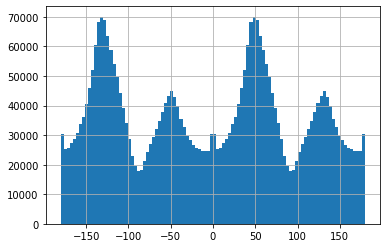

In [13]:
# make the same histogram plot as the rose diagram below
(180*df_sym['angle']/np.pi).hist(bins=100)
plt.show()

In [14]:
# Pandas 0.25.0+
angles = np.linspace(-np.pi, np.pi, 128+1, endpoint=True)
labels = (angles[1:] + angles[:-1])/2
df_sym['sector'] = labels[np.digitize(df_sym.angle, angles)-1]
df_sym_sector = df_sym.groupby(['sector']).agg(num = ('sector','count'),length = ('length','sum')).reset_index()

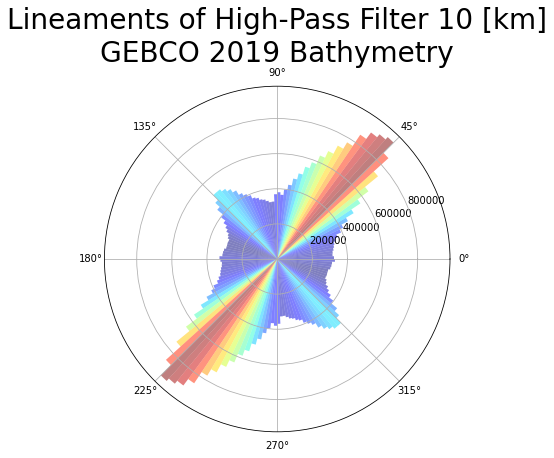

In [15]:
# force square figure and square axes looks better for polar, IMO
fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)

theta = df_sym_sector.sector.values
radii = df_sym_sector.length.values
width = np.diff(angles)[0]

bars = ax.bar(theta, radii, width=width, bottom=0.0)
for r,bar in zip(radii, bars):
    bar.set_facecolor( cm.jet((r-np.min(radii))/(np.max(radii)-np.min(radii))))
    bar.set_alpha(0.5)

plt.title(f'Lineaments of High-Pass Filter {sigmakm} [km]\nGEBCO 2019 Bathymetry', fontsize=28)
plt.savefig(f'IsoLineaments of High-Pass Filter {sigmakm} [km] GEBCO 2019 Bathymetry.jpg', \
            bbox_inches='tight', dpi=150, pil_kwargs={'quality': 95})
plt.show()